In [2]:
import torch  # now import the tensorflow module
from torch import nn
import numpy as np 
print(torch.__version__)  # check the version

1.12.1


## Q1

In [3]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

col_names = ["duration","protocol_type","service","flag","src_bytes",
"dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
"logged_in","num_compromised","root_shell","su_attempted","num_root",
"num_file_creations","num_shells","num_access_files","num_outbound_cmds",
"is_host_login","is_guest_login","count","srv_count","serror_rate",
"srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
"diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
"dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","class","difficulty"]

nominal_cols = ['protocol_type','service','flag']
binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
'is_guest_login']
continuous_cols = ['duration' ,'src_bytes', 'dst_bytes', 'wrong_fragment' ,'urgent', 'hot',
'num_failed_logins', 'num_compromised', 'num_root' ,'num_file_creations',
'num_shells', 'num_access_files', 'num_outbound_cmds', 'count' ,'srv_count',
'serror_rate', 'srv_serror_rate' ,'rerror_rate' ,'srv_rerror_rate',
'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate' ,'dst_host_count',
'dst_host_srv_count' ,'dst_host_same_srv_rate' ,'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate' ,'dst_host_srv_diff_host_rate',
'dst_host_serror_rate' ,'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']


DoS=['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
Probe=['ipsweep','mscan','nmap','portsweep','saint','satan']
U2R = ['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm']
R2L = ['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','Snmpgetattack','spy',
      'snmpguess','warezclient','warezmaster','xlock','xsnoop']


class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        label_to_binary = udf(lambda name: 0.0 if name == 'normal' else 1.0 if name in DoS else 2.0 if name in Probe
                             else 3.0 if name in U2R else 4.0)
        output_df = dataset.withColumn('outcome', label_to_binary(col('class'))).drop("class")  
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        output_df = output_df.drop('difficulty')
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                     "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    

    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    return pipeline 


In [4]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("GenericAppName") \
    .getOrCreate()

nslkdd_raw = spark.read.csv('./KDDTrain+.txt',header=False).toDF(*col_names)
nslkdd_test_raw = spark.read.csv('./KDDTest+.txt',header=False).toDF(*col_names)
preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(nslkdd_raw)

nslkdd_df = preprocess_pipeline_model.transform(nslkdd_raw)
nslkdd_df_test = preprocess_pipeline_model.transform(nslkdd_test_raw)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/16 17:18:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


22/11/16 17:18:43 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

nslkdd_df_train = nslkdd_df 
nslkdd_df_validate,nslkdd_df_test = nslkdd_df_test.randomSplit([0.5,0.5])

In [6]:
nslkdd_df_train_pandas = nslkdd_df_train.withColumn('features', to_array('features')).toPandas()
nslkdd_df_validate_pandas = nslkdd_df_validate.withColumn('features', to_array('features')).toPandas()
nslkdd_df_test_pandas = nslkdd_df_test.withColumn('features', to_array('features')).toPandas()

In [7]:
from torch.utils.data import Dataset, DataLoader

x_train = torch.from_numpy(np.array(nslkdd_df_train_pandas['features'].values.tolist(),np.float32))
y_train = torch.from_numpy(np.array(nslkdd_df_train_pandas['outcome'].values.tolist(),np.int64))

x_validate = torch.from_numpy(np.array(nslkdd_df_validate_pandas['features'].values.tolist(),np.float32))
y_validate = torch.from_numpy(np.array(nslkdd_df_validate_pandas['outcome'].values.tolist(),np.int64))

x_test = torch.from_numpy(np.array(nslkdd_df_test_pandas['features'].values.tolist(),np.float32))
y_test = torch.from_numpy(np.array(nslkdd_df_test_pandas['outcome'].values.tolist(),np.int64))

In [8]:
# Defining MyDataset Class
class MyDataset(Dataset): 
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return (self.x[idx],self.y[idx])

# Turning the data from tensors to datasets
train_dataset = MyDataset(x_train,y_train)
validate_dataset = MyDataset(x_validate,y_validate)
test_dataset = MyDataset(x_test,y_test)

## Q2

In [9]:
from torch import nn

# Example: using Sequential in Pytorch

class myMultiLayerPerceptron(nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.sequential = nn.Sequential(  # here we stack multiple layers together
            nn.Linear(input_dim,20),
            nn.ReLU(),
            nn.Linear(20,20),
            nn.ReLU(),
            nn.Linear(20,20),
            nn.ReLU(),
            nn.Linear(20,output_dim)
        )
    def forward(self,x):
        y = self.sequential(x)
        return y
    
# Let's check out our model 

mymodel = myMultiLayerPerceptron(113,5) # 5 = number of classes 

print(mymodel)

myMultiLayerPerceptron(
  (sequential): Sequential(
    (0): Linear(in_features=113, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=5, bias=True)
  )
)


In [10]:
x_train.shape[1]

113

## Q3

In [11]:
mymodel = myMultiLayerPerceptron(113,5) 


lr = .005
batch_size = 64
N_epochs = 10


loss_fun = nn.CrossEntropyLoss()


train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validate_dataloader = DataLoader(validate_dataset,batch_size = batch_size,shuffle = True)


optimizer = torch.optim.Adam(mymodel.parameters(), lr = lr) 

n = 0
losses_SGD = []
losses = [] # training losses of each epoch
accuracies = [] # training accuracies of each epoch

validate_losses = [] # validation losses of each epoch
validate_accuracies = [] # validation accuracies of each epoch

current_best_accuracy = 0.0

for epoch in range(N_epochs):
    # Train loop
    batch_loss = [] 
    batch_accuracy = [] 
    for x_batch, y_batch in train_dataloader:
      
        prediction_score = mymodel(x_batch)  
        loss = loss_fun(prediction_score,y_batch)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        batch_loss.append(loss.detach().numpy()) 
        prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
        batch_accuracy.append( np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0]) 
        losses_SGD.append(loss.detach())
        n+=1
    
    validate_batch_loss = [] 
    validate_batch_accuracy = [] 
    for x_batch, y_batch in validate_dataloader:

        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score,y_batch)

        validate_batch_loss.append(loss.detach())

        prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
        validate_batch_accuracy.append( np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0]) 
    
    
    losses.append(np.mean(np.array(batch_loss)))
    validate_losses.append( np.mean(np.array(validate_batch_loss)))
    accuracies.append(np.mean(np.array(batch_accuracy)))
    validate_accuracies.append(np.mean(np.array(validate_batch_accuracy)))

    print(f"Epoch = {epoch},train_loss={losses[-1]},validate_loss={validate_losses[-1]}")
    print(f"Train accuracy = {np.round(accuracies[-1]*100,2)}%, validate accuracy = {np.round(validate_accuracies[-1]*100,2)}% ")
 
    if validate_accuracies[-1]>current_best_accuracy:
        print("Current epoch is the best so far. Saving model...") 
        torch.save(mymodel.state_dict(),'current_best_model')
        current_best_accuracy = validate_accuracies[-1]



Epoch = 0,train_loss=0.07523807138204575,validate_loss=2.1963398456573486
Train accuracy = 97.65%, validate accuracy = 74.58% 
Current epoch is the best so far. Saving model...
Epoch = 1,train_loss=0.032041504979133606,validate_loss=1.9377758502960205
Train accuracy = 98.97%, validate accuracy = 75.59% 
Current epoch is the best so far. Saving model...
Epoch = 2,train_loss=0.02714543603360653,validate_loss=2.5595076084136963
Train accuracy = 99.1%, validate accuracy = 75.04% 
Epoch = 3,train_loss=0.02520858868956566,validate_loss=2.3195908069610596
Train accuracy = 99.18%, validate accuracy = 78.39% 
Current epoch is the best so far. Saving model...
Epoch = 4,train_loss=0.02364867925643921,validate_loss=2.871175527572632
Train accuracy = 99.23%, validate accuracy = 76.55% 
Epoch = 5,train_loss=0.022832045331597328,validate_loss=3.3104116916656494
Train accuracy = 99.27%, validate accuracy = 75.17% 
Epoch = 6,train_loss=0.02134726755321026,validate_loss=2.7860379219055176
Train accuracy

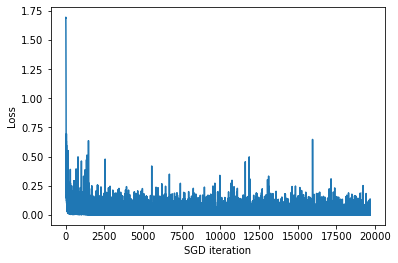

In [12]:
# Plot train loss per SGD iteration
from matplotlib import pyplot as plt
losses_SGD_overall = []
for i in losses_SGD:
    losses_SGD_overall.append(i.item())
plt.plot(range(n),losses_SGD_overall,label='Validate Loss')
plt.xlabel("SGD iteration")
plt.ylabel("Loss")
plt.show()

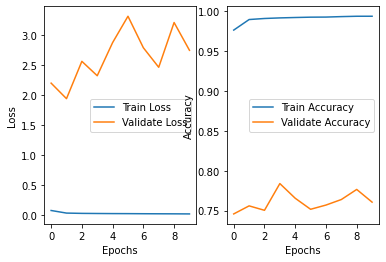

In [13]:
# Plot train/validate loss and metrics across different epochs
fig,axes = plt.subplots(nrows=1,ncols=2)

axes[0].plot(range(N_epochs),losses,label='Train Loss')
axes[0].plot(range(N_epochs),validate_losses,label='Validate Loss')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(range(N_epochs),accuracies,label='Train Accuracy')
axes[1].plot(range(N_epochs),validate_accuracies,label='Validate Accuracy')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

## Q4

In [20]:
def training(lr_input, batch_size_input, N_epochs_input):
    mymodel = myMultiLayerPerceptron(113,5)
    lr = lr_input
    batch_size = batch_size_input
    N_epochs = N_epochs_input

    # Create loss function
    loss_fun = nn.CrossEntropyLoss()

    # Create dataloaders for training and validation
    train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    validate_dataloader = DataLoader(validate_dataset,batch_size = batch_size,shuffle = True)

    # Create optimizer
    optimizer = torch.optim.Adam(mymodel.parameters(), lr = lr) # this line creates a optimizer, and we tell optimizer we are optimizing the parameters in mymodel

    n = 0
    losses_SGD = []
    losses = [] # training losses of each epoch
    accuracies = [] # training accuracies of each epoch

    validate_losses = [] # validation losses of each epoch
    validate_accuracies = [] # validation accuracies of each epoch

    current_best_accuracy = 0.0

    for epoch in range(N_epochs):
        # Train loop
        batch_loss = [] # keep a list of losses for different batches in this epoch
        batch_accuracy = [] # keep a list of accuracies for different batches in this epoch
        for x_batch, y_batch in train_dataloader:
            # pass input data to get the prediction outputs by the current model
            prediction_score = mymodel(x_batch)  


            # compute the cross entropy loss. Note that the first input to the loss_func should be the predicted scores (not probabilities), and the second input should be class labels as integers
            loss = loss_fun(prediction_score,y_batch)

            # compute the gradient
            optimizer.zero_grad()
            loss.backward()

            # update parameters with optimizer step
            optimizer.step()

            # append the loss of this batch to the batch_loss list
            batch_loss.append(loss.detach().numpy())
            # You can also compute other metrics (accuracy) for this batch here 
            prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
            batch_accuracy.append( np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0]) 
            losses_SGD.append(loss.detach())
            n+=1

        # Validation loop
        validate_batch_loss = [] # keep a list of losses for different validate batches in this epoch
        validate_batch_accuracy = [] # same for the accuracy
        for x_batch, y_batch in validate_dataloader:
            # pass input data to get the prediction outputs by the current model
            prediction_score = mymodel(x_batch)

            # compare prediction and the actual output and compute the loss
            loss = loss_fun(prediction_score,y_batch)

            # append the loss of this batch to the validate_batch_loss list
            validate_batch_loss.append(loss.detach())

            # You can also compute other metrics (like accuracy) for this batch here
            prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
            validate_batch_accuracy.append( np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0]) 


        # calculate the average train loss and validate loss in this epoch and record them
        losses.append(np.mean(np.array(batch_loss)))
        validate_losses.append( np.mean(np.array(validate_batch_loss)))
        # You can also compute other metrics for this epoch here
        accuracies.append(np.mean(np.array(batch_accuracy)))
        validate_accuracies.append(np.mean(np.array(validate_batch_accuracy)))

        # Printing
        print(f"Epoch = {epoch},train_loss={losses[-1]},validate_loss={validate_losses[-1]}")
        print(f"Train accuracy = {np.round(accuracies[-1]*100,2)}%, validate accuracy = {np.round(validate_accuracies[-1]*100,2)}% ")

        # If the validate metric of this epoch is the best so far, save the model
        if validate_accuracies[-1]>current_best_accuracy:
            print("Current epoch is the best so far. Saving model...") 
            torch.save(mymodel.state_dict(),'current_best_model')
            current_best_accuracy = validate_accuracies[-1]
    return current_best_accuracy,  losses_SGD, losses, validate_losses, accuracies, validate_accuracies, N_epochs, n




Original parameters:
#lr = .005
#batch_size = 64
#N_epochs = 10

I will start by tuning the learning rate to see the result. My first try is to increase the learning rate to 0.05 and I find that my best accuracy is 74.46% and there is a lot of randomness. Nextly, I try to decrease the learning rate to 0.001 which improves accuracy and reduces randomness a lot. Finally, I try to decrease my batch size to 32 and also decrease my learning rate to 0.0005 attempting to further enhances accuracy while maintaining stable randomness. As a result, my accuracy increases to 79.5%. Please read through my code below.

In [21]:
# Try to increase lr
acc1, losses_SGD1, losses1, validate_losses1, accuracies1, validate_accuracies1, N_epochs1, n1 = training(0.05,64,10)

Epoch = 0,train_loss=0.11036339402198792,validate_loss=1.7064591646194458
Train accuracy = 96.86%, validate accuracy = 71.7% 
Current epoch is the best so far. Saving model...
Epoch = 1,train_loss=0.21846455335617065,validate_loss=2.0540778636932373
Train accuracy = 92.75%, validate accuracy = 64.21% 
Epoch = 2,train_loss=0.22281178832054138,validate_loss=2.348375082015991
Train accuracy = 92.49%, validate accuracy = 71.55% 
Epoch = 3,train_loss=0.1723930686712265,validate_loss=2.557326316833496
Train accuracy = 93.82%, validate accuracy = 70.9% 
Epoch = 4,train_loss=0.15981385111808777,validate_loss=3.632873296737671
Train accuracy = 94.63%, validate accuracy = 74.46% 
Current epoch is the best so far. Saving model...
Epoch = 5,train_loss=0.16018766164779663,validate_loss=3.742250919342041
Train accuracy = 94.44%, validate accuracy = 73.98% 
Epoch = 6,train_loss=0.15039809048175812,validate_loss=4.391879558563232
Train accuracy = 94.57%, validate accuracy = 73.42% 
Epoch = 7,train_los

Best Accuracy 0.7445596246973366


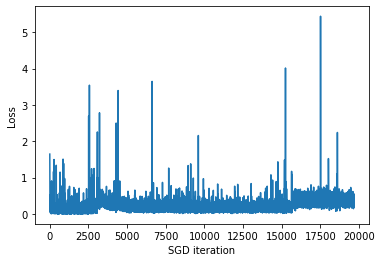

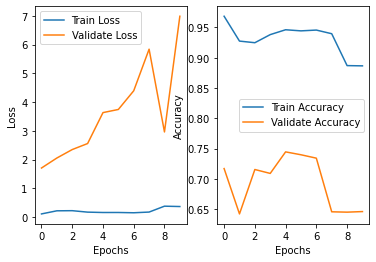

In [22]:
print('Best Accuracy',acc1)

losses_SGD_overall = []
for i in losses_SGD1:
    losses_SGD_overall.append(i.item())
plt.plot(range(n1),losses_SGD_overall,label='Validate Loss')
plt.xlabel("SGD iteration")
plt.ylabel("Loss")
plt.show()

fig,axes = plt.subplots(nrows=1,ncols=2)
axes[0].plot(range(N_epochs1),losses1,label='Train Loss')
axes[0].plot(range(N_epochs1),validate_losses1,label='Validate Loss')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(range(N_epochs1),accuracies1,label='Train Accuracy')
axes[1].plot(range(N_epochs1),validate_accuracies1,label='Validate Accuracy')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

In [23]:
# Since there are a lot of randomness, we try to decrease lr
acc2, losses_SGD2, losses2, validate_losses2, accuracies2, validate_accuracies2, N_epochs2, n2 = training(0.001,64,12)

Epoch = 0,train_loss=0.12215909361839294,validate_loss=1.6932963132858276
Train accuracy = 95.79%, validate accuracy = 76.6% 
Current epoch is the best so far. Saving model...
Epoch = 1,train_loss=0.033739179372787476,validate_loss=2.178602933883667
Train accuracy = 98.93%, validate accuracy = 76.25% 
Epoch = 2,train_loss=0.027299117296934128,validate_loss=2.3580102920532227
Train accuracy = 99.11%, validate accuracy = 77.89% 
Current epoch is the best so far. Saving model...
Epoch = 3,train_loss=0.023920925334095955,validate_loss=2.776005744934082
Train accuracy = 99.23%, validate accuracy = 76.08% 
Epoch = 4,train_loss=0.022758986800909042,validate_loss=2.7806150913238525
Train accuracy = 99.27%, validate accuracy = 78.56% 
Current epoch is the best so far. Saving model...
Epoch = 5,train_loss=0.020929811522364616,validate_loss=3.132411003112793
Train accuracy = 99.32%, validate accuracy = 76.7% 
Epoch = 6,train_loss=0.019944552332162857,validate_loss=3.200164318084717
Train accuracy

Best Accuracy 0.7856386198547216


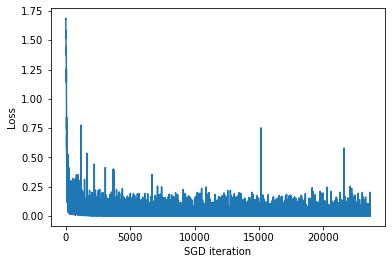

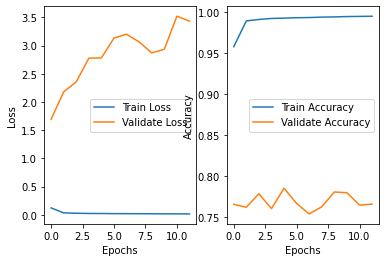

In [24]:
print('Best Accuracy',acc2)

losses_SGD_overall = []
for i in losses_SGD2:
    losses_SGD_overall.append(i.item())
plt.plot(range(n2),losses_SGD_overall,label='Validate Loss')
plt.xlabel("SGD iteration")
plt.ylabel("Loss")
plt.show()



fig,axes = plt.subplots(nrows=1,ncols=2)
axes[0].plot(range(N_epochs2),losses2,label='Train Loss')
axes[0].plot(range(N_epochs2),validate_losses2,label='Validate Loss')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(range(N_epochs2),accuracies2,label='Train Accuracy')
axes[1].plot(range(N_epochs2),validate_accuracies2,label='Validate Accuracy')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

In [31]:
acc3, losses_SGD3, losses3, validate_losses3, accuracies3, validate_accuracies3, N_epochs3, n3 = training(0.0005,32,12)

Epoch = 0,train_loss=0.1343475580215454,validate_loss=1.8031750917434692
Train accuracy = 95.46%, validate accuracy = 73.29% 
Current epoch is the best so far. Saving model...
Epoch = 1,train_loss=0.03675466030836105,validate_loss=1.7841753959655762
Train accuracy = 98.79%, validate accuracy = 78.85% 
Current epoch is the best so far. Saving model...
Epoch = 2,train_loss=0.028471264988183975,validate_loss=1.9530029296875
Train accuracy = 99.05%, validate accuracy = 79.5% 
Current epoch is the best so far. Saving model...
Epoch = 3,train_loss=0.025889761745929718,validate_loss=2.314561367034912
Train accuracy = 99.13%, validate accuracy = 77.32% 
Epoch = 4,train_loss=0.023364931344985962,validate_loss=2.4159438610076904
Train accuracy = 99.25%, validate accuracy = 77.88% 
Epoch = 5,train_loss=0.02272377908229828,validate_loss=2.5073180198669434
Train accuracy = 99.3%, validate accuracy = 75.98% 
Epoch = 6,train_loss=0.02112659066915512,validate_loss=2.6141552925109863
Train accuracy = 9

Best Accuracy 0.795021186440678


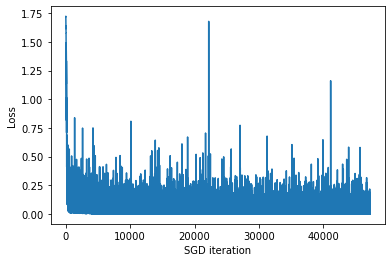

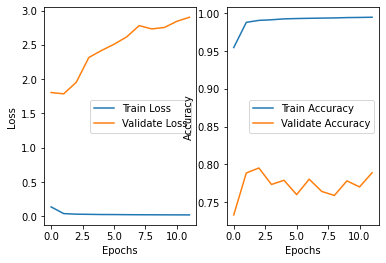

In [32]:
print('Best Accuracy',acc3)

losses_SGD_overall = []
for i in losses_SGD3:
    losses_SGD_overall.append(i.item())
plt.plot(range(n3),losses_SGD_overall,label='Validate Loss')
plt.xlabel("SGD iteration")
plt.ylabel("Loss")
plt.show()



fig,axes = plt.subplots(nrows=1,ncols=2)
axes[0].plot(range(N_epochs3),losses3,label='Train Loss')
axes[0].plot(range(N_epochs3),validate_losses3,label='Validate Loss')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(range(N_epochs3),accuracies3,label='Train Accuracy')
axes[1].plot(range(N_epochs3),validate_accuracies3,label='Validate Accuracy')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

# Q5

In [33]:
# create a new model with the same input-output dimension as before
mybestmodel = myMultiLayerPerceptron(x_train.shape[1],5)

# load the "state_dict" from file into the new model
mybestmodel.load_state_dict(torch.load("current_best_model"))

# conduct testing via a test loop
test_dataloader = DataLoader(test_dataset,batch_size = batch_size,shuffle = True)
test_batch_accuracy = []
for x_batch, y_batch in test_dataloader:
    # pass input data to get the prediction outputs 
    prediction_score = mybestmodel(x_batch)

    # Compute metrics (like accuracy) for this batch here
    prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
    test_batch_accuracy.append( np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0]) 

# compute the mean accuracy across all batches
test_accuracy = np.mean(np.array(test_batch_accuracy))

print(f"Test accuracy = {np.round(test_accuracy*100,2)}%")

Test accuracy = 80.29%
